In [1]:
# --------------------- Import các thư viện cần thiết ---------------------

from tqdm import tqdm  #Hiển thị thanh tiến trình.
import time            #Đo thời gian thực thi.
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, ElectraTokenizer, ElectraModel #Thư viện cung cấp mô hình pre-trained như ELECTRA.
from torch.optim import AdamW
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
#----------------------Xử lý data-Chia tập dữ liệu huấn luyện---------------------------------


# Đọc dataset đã qua tiền xử lý dữ liệu
data_df = pd.read_csv('/kaggle/input/dataset-sentiment-v5/dataset_process_v5.csv')


# Đảm bảo comment là chuỗi
data_df['comment'] = [str(text) for text in data_df['comment']]

# Đảm bảo nhãn là kiểu số nguyên
data_df['label'] = data_df['label'].astype(int)

print("\nTổng số lượng comment: ",len(data_df))

def split_data(df, split_size):
    train_size = int(split_size[0] * len(df))
    val_size = int(split_size[1] * len(df))

    df_train = df[:train_size]
    df_val = df[train_size:train_size+val_size]
    df_test = df[train_size + val_size:]
    return df_train, df_val, df_test

# Chia tập dữ liệu
split = [0.7, 0.15, 0.15]
train_data, val_data, test_data = split_data(data_df, split)


print("\nSố lượng dữ liệu trong tập train:", len(train_data))
print(train_data[0:20])
print("\nSố lượng dữ liệu trong tập validation:", len(val_data))
print(val_data[0:5])
print("\nSố lượng dữ liệu trong tập test:", len(test_data))
print(test_data[0:5])


Tổng số lượng comment:  34468

Số lượng dữ liệu trong tập train: 24127
                                              comment  label
0   hàng đẹp vừa giá tiền nhưng k biết bên trong g...      0
1   chất_lượng sản_phẩm rất kémshop giao hàng đã q...      1
2   máy êm dùng tốt k bit cách sử_dụng nhiệt_tình ...      0
3   tiền_nào_của_đó giao đôi giầy hai hãng khác nh...      1
4                                            cứng quá      1
5   thời_gian giao hàng rất nhanh của em bị nhầm t...      1
6   mua gần chục đôi giao hàng lỗi gọi ko trả_lời ...      1
7   thời_gian giao hàng rất nhanh nhân_viên giao h...      0
8                ko thích chất_lượng sản_phẩm rất kém      1
9   chất_lượng sản_phẩm tuyệt_vời rất phù_hợp giá ...      0
10  bán hàng tư_vấn dễ_thương lần mua cũng có quà ...      0
11  chữ đọc được chữ không thấy                   ...      1
12  đóng_gói sản_phẩm kém giao hàng ko đúng màu nh...      1
13                                không đúng sản_phẩm      1
14           

In [3]:
# --------------------- 1. Dataset Class ---------------------

class Sentiment_Comment_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Khởi tạo dataset với các tham số:
        - texts: Danh sách các văn bản (câu) đầu vào.
        - labels: Danh sách nhãn tương ứng với các văn bản.
        - tokenizer: Tokenizer để mã hóa văn bản.
        - max_length: Độ dài tối đa của mỗi đoạn mã hóa.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = self.tokenize_texts()  # Tạo danh sách các mẫu dữ liệu

    def tokenize_texts(self):
        """
        Tokenize các văn bản. Mỗi văn bản được mã hóa thành một đoạn duy nhất.
        """
        examples = []
        for text, label in zip(self.texts, self.labels):
            tokenized = self.tokenizer(
                text,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            examples.append((tokenized["input_ids"].squeeze(0), tokenized["attention_mask"].squeeze(0), label))
        return examples

    def __len__(self):
        """
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Trả về một mẫu dữ liệu theo chỉ số.
        """
        input_ids, attention_mask, label = self.examples[idx]
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [4]:

# # --------------------- 2. Transformer Model -----------------------

# # Mô hình cơ bản: TransformerELECTRA
# # Sử dụng mô hình ElectraModel để trích xuất đặc trưng.
# # Kết nối với lớp phân loại (nn.Linear) để đưa ra kết quả.
# class TransformerELECTRA(nn.Module):
#     def __init__(self, model_name='google/electra-base-discriminator', num_labels=2):
#         super(TransformerELECTRA, self).__init__()
#         self.electra = ElectraModel.from_pretrained(model_name)
#         self.classifier = nn.Linear(self.electra.config.hidden_size, num_labels)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
#         sequence_output = outputs.last_hidden_state
#         cls_token_output = sequence_output[:, 0, :]
#         cls_token_output = self.dropout(cls_token_output)
#         logits = self.classifier(cls_token_output)
#         return logits


# Mô hình cải tiến: CustomELECTRAModel
# Thêm cơ chế Attention để trọng số hóa các đặc trưng quan trọng: self.attention = nn.MultiheadAttention(...)
# Lớp LayerNorm cải thiện ổn định trong huấn luyện.
class CustomELECTRAModel(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super(CustomELECTRAModel, self).__init__()
        self.electra = ElectraModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(
            embed_dim=self.electra.config.hidden_size, 
            num_heads=8, 
            batch_first=True
        )
        self.fc1 = nn.Linear(self.electra.config.hidden_size, 128)
        self.fc2 = nn.Linear(128, num_labels)
        self.dropout = nn.Dropout(0.45)
        
        # Thêm lớp LayerNorm
        self.layer_norm = nn.LayerNorm(128)

    def forward(self, input_ids, attention_mask):
        # Trích xuất embeddings từ ELECTRA
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Attention pooling
        attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool())
        
        # Chọn CLS token làm đặc trưng đại diện
        cls_token_output = attn_output[:, 0, :]  # CLS token tương ứng với đầu tiên của sequence output

        # Fully connected layers
        pooled_output = self.dropout(cls_token_output)  # Áp dụng dropout
        fc1_output = torch.relu(self.fc1(pooled_output))
        
        # Áp dụng Layer Normalization sau FC1
        fc1_output = self.layer_norm(fc1_output)
        
        logits = self.fc2(fc1_output)
        return logits


# --------------------- 3. Trainer Class -----------------------------------------

# Tập trung vào huấn luyện và đánh giá mô hình.
class ClassifierTrainer:
    def __init__(self, model, train_dataloader, val_dataloader, device, lr=2e-5, epochs=3, accumulation_steps=4, checkpoint_dir="/kaggle/working/"):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.lr = lr
        self.epochs = epochs
        self.accumulation_steps = accumulation_steps
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.9)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.amp.GradScaler()  # Mixed Precision
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Lưu loss và accuracy để vẽ biểu đồ
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    # Huấn luyện một epoch
    # Chạy từng batch dữ liệu qua mô hình.
    # Tính toán và tối ưu hóa loss.
    # Sử dụng autocast và GradScaler để tăng tốc với Mixed Precision.
    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss, total_correct = 0, 0
        previous_percent = 0  # Biến lưu trữ tiến độ trước đó
    
        print(f"Epoch {epoch + 1}: Training...")
        start_time = time.time()

        for step, batch in enumerate(self.train_dataloader):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)
    
            with torch.amp.autocast(device_type='cuda'):  # Mixed Precision
                logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = self.criterion(logits, labels) / self.accumulation_steps
    
            self.scaler.scale(loss).backward()
    
            if (step + 1) % self.accumulation_steps == 0 or (step + 1) == len(self.train_dataloader):
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
    
            total_loss += loss.item() * self.accumulation_steps
            total_correct += (logits.argmax(dim=-1) == labels).sum().item()
    
            # Tính phần trăm hoàn thành
            current_percent = int(100 * (step + 1) / len(self.train_dataloader))
            if current_percent != previous_percent:  # Chỉ in khi phần trăm thay đổi
                previous_percent = current_percent
                avg_loss = total_loss / (step + 1)
                accuracy = total_correct / ((step + 1) * self.train_dataloader.batch_size)
                print(f"Progress: {current_percent}% | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

        epoch_time = time.time() - start_time
        print(f"  Training completed in {epoch_time:.2f} seconds.")
        avg_loss = total_loss / len(self.train_dataloader)
        accuracy = total_correct / len(self.train_dataloader.dataset)
        
        # Lưu giá trị loss và accuracy cho vẽ biểu đồ
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
    
        return avg_loss, accuracy

    # Đánh giá mô hình
    # Đánh giá trên tập validation.
    # Tính loss, accuracy và lưu các giá trị để vẽ biểu đồ.
    def evaluate(self, epoch):
        """
        Đánh giá trên tập Validation.
        """
        self.model.eval()
        total_loss, total_correct = 0, 0
        all_labels = []  # Khởi tạo danh sách trống
        all_preds = []   # Khởi tạo danh sách trống
        previous_percent = 0  # Biến lưu trữ tiến độ trước đó
    
        print(f"Epoch {epoch + 1}: Evaluating (Validation)...")
        start_time = time.time()
    
        with torch.no_grad():
            for step, batch in enumerate(self.val_dataloader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)
    
                with torch.amp.autocast(device_type='cuda'):
                    logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = self.criterion(logits, labels)
    
                total_loss += loss.item()
                total_correct += (logits.argmax(dim=-1) == labels).sum().item()
    
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(logits.argmax(dim=-1).cpu().numpy())
    
                # Tính phần trăm hoàn thành
                current_percent = int(100 * (step + 1) / len(self.val_dataloader))
                if current_percent != previous_percent:  # Chỉ in khi phần trăm thay đổi
                    previous_percent = current_percent
                    avg_loss = total_loss / (step + 1)
                    accuracy = total_correct / ((step + 1) * self.val_dataloader.batch_size)
                    print(f"Progress: {current_percent}% | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
    
        epoch_time = time.time() - start_time
        print(f"  Validation completed in {epoch_time:.2f} seconds.")
        avg_loss = total_loss / len(self.val_dataloader)
        accuracy = total_correct / len(self.val_dataloader.dataset)
        
        # Lưu giá trị loss và accuracy cho vẽ biểu đồ
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
    
        return avg_loss, accuracy


    # Hàm huấn luyện
    def train(self):
        best_val_acc = 0.0
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_one_epoch(epoch)
            val_loss, val_acc = self.evaluate(epoch)

            self.scheduler.step()

            print(f"Epoch {epoch + 1}/{self.epochs}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

            # Lưu mô hình tốt nhất
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_best_checkpoint(epoch, val_acc)
                
        # Hiển thị kết quả cuối cùng
        final_train_loss = self.train_losses[-1]
        final_train_acc = self.train_accuracies[-1]
        final_val_loss = self.val_losses[-1]
        final_val_acc = self.val_accuracies[-1]
    
        print("\n===== Training Completed =====")
        print(f"Final Train Loss: {final_train_loss:.4f} | Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Val Loss: {final_val_loss:.4f} | Final Val Accuracy: {final_val_acc:.4f}")

    # Vẽ biểu đồ Loss và Accuracy theo từng epoch.
    def plot_metrics(self):
        epochs_range = range(1, self.epochs + 1)

        # Vẽ biểu đồ loss
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, self.train_losses, label='Train Loss')
        plt.plot(epochs_range, self.val_losses, label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Vẽ biểu đồ accuracy
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs_range, self.val_accuracies, label='Val Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Lưu trạng thái mô hình có độ chính xác cao nhất trên tập validation.
    def save_best_checkpoint(self, epoch, val_acc):
        """
        Lưu checkpoint tốt nhất.
        """
        checkpoint_path = os.path.join(self.checkpoint_dir, f"best_model_epoch_{epoch + 1}_val_acc_{val_acc:.4f}.pth")
        torch.save(self.model, checkpoint_path)
        print(f"  Saved best model to {checkpoint_path}") 

In [5]:
!pip install ipywidgets --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [6]:
# --------------------- 4. Dataset và Dataloader ---------------------

# Tải mô hình ELECTRA-Base
model_name='google/electra-base-discriminator' 
tokenizer = ElectraTokenizer.from_pretrained(model_name)

# Lưu tokenizer
tokenizer.save_pretrained("/kaggle/working/tokenizer")

train_dataset = Sentiment_Comment_Dataset(
    texts=train_data['comment'].tolist(),
    labels=train_data['label'].tolist(),
    tokenizer=tokenizer
)
print(f"\nSố lượng mẫu train: từ {len(train_data)} mẫu đã tăng lên {len(train_dataset)} mẫu")

val_dataset = Sentiment_Comment_Dataset(
    texts=val_data['comment'].tolist(),
    labels=val_data['label'].tolist(),
    tokenizer=tokenizer
)
print(f"\nSố lượng mẫu val: từ {len(val_data)} mẫu đã tăng lên {len(val_dataset)} mẫu")
#DataLoader Optimization
# Tối ưu hóa DataLoader:
# Sử dụng pin_memory và num_workers để tăng tốc độ nạp dữ liệu.
# Có collate_fn để xử lý batch đầu vào cho mô hình

# Hàm collate_fn , mỗi batch sẽ có 3 trường dữ liệu
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': labels}
    
#shuffle=True: Mỗi khi một epoch mới bắt đầu, các mẫu trong tập dữ liệu huấn luyện sẽ được trộn ngẫu nhiên
# Tạo DataLoader với collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]


Số lượng mẫu train: từ 24127 mẫu đã tăng lên 24127 mẫu

Số lượng mẫu val: từ 5170 mẫu đã tăng lên 5170 mẫu


In [7]:
# --------------------- 5. Huấn luyện mô hình ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomELECTRAModel(model_name).to(device)

trainer = ClassifierTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    lr=2e-5,
    epochs=20,
    accumulation_steps=4
)

trainer.train()  # Huấn luyện mô hình

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Training...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Progress: 1% | Loss: 0.7665 | Accuracy: 0.4563
Progress: 2% | Loss: 0.7428 | Accuracy: 0.5041
Progress: 3% | Loss: 0.7388 | Accuracy: 0.5027
Progress: 4% | Loss: 0.7401 | Accuracy: 0.4918
Progress: 5% | Loss: 0.7378 | Accuracy: 0.4926
Progress: 6% | Loss: 0.7293 | Accuracy: 0.5048
Progress: 7% | Loss: 0.7263 | Accuracy: 0.5077
Progress: 8% | Loss: 0.7189 | Accuracy: 0.5176
Progress: 9% | Loss: 0.7111 | Accuracy: 0.5262
Progress: 10% | Loss: 0.7045 | Accuracy: 0.5351
Progress: 11% | Loss: 0.6977 | Accuracy: 0.5462
Progress: 12% | Loss: 0.6925 | Accuracy: 0.5520
Progress: 13% | Loss: 0.6865 | Accuracy: 0.5623
Progress: 14% | Loss: 0.6764 | Accuracy: 0.5733
Progress: 15% | Loss: 0.6685 | Accuracy: 0.5842
Progress: 16% | Loss: 0.6598 | Accuracy: 0.5945
Progress: 17% | Loss: 0.6520 | Accuracy: 0.6033
Progress: 18% | Loss: 0.6429 | Accuracy: 0.6123
Progress: 19% | Loss: 0.6362 | Accuracy: 0.6199
Progress: 20% | Loss: 0.6262 | Accuracy: 0.6292
Progress: 21% | Loss: 0.6190 | Accuracy: 0.6357
P

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Progress: 100% | Loss: 0.4338 | Accuracy: 0.7818
  Training completed in 315.12 seconds.
Epoch 1: Evaluating (Validation)...
Progress: 1% | Loss: 0.4077 | Accuracy: 0.7667
Progress: 2% | Loss: 0.3864 | Accuracy: 0.7870
Progress: 3% | Loss: 0.3976 | Accuracy: 0.7756
Progress: 4% | Loss: 0.3733 | Accuracy: 0.7963
Progress: 5% | Loss: 0.3553 | Accuracy: 0.8068
Progress: 6% | Loss: 0.3472 | Accuracy: 0.8109
Progress: 7% | Loss: 0.3601 | Accuracy: 0.8011
Progress: 8% | Loss: 0.3713 | Accuracy: 0.7952
Progress: 9% | Loss: 0.3514 | Accuracy: 0.8120
Progress: 10% | Loss: 0.3525 | Accuracy: 0.8106
Progress: 11% | Loss: 0.3562 | Accuracy: 0.8090
Progress: 12% | Loss: 0.3598 | Accuracy: 0.8077
Progress: 13% | Loss: 0.3638 | Accuracy: 0.8041
Progress: 14% | Loss: 0.3589 | Accuracy: 0.8060
Progress: 15% | Loss: 0.3583 | Accuracy: 0.8026
Progress: 16% | Loss: 0.3563 | Accuracy: 0.8068
Progress: 17% | Loss: 0.3531 | Accuracy: 0.8086
Progress: 18% | Loss: 0.3555 | Accuracy: 0.8066
Progress: 19% | Loss

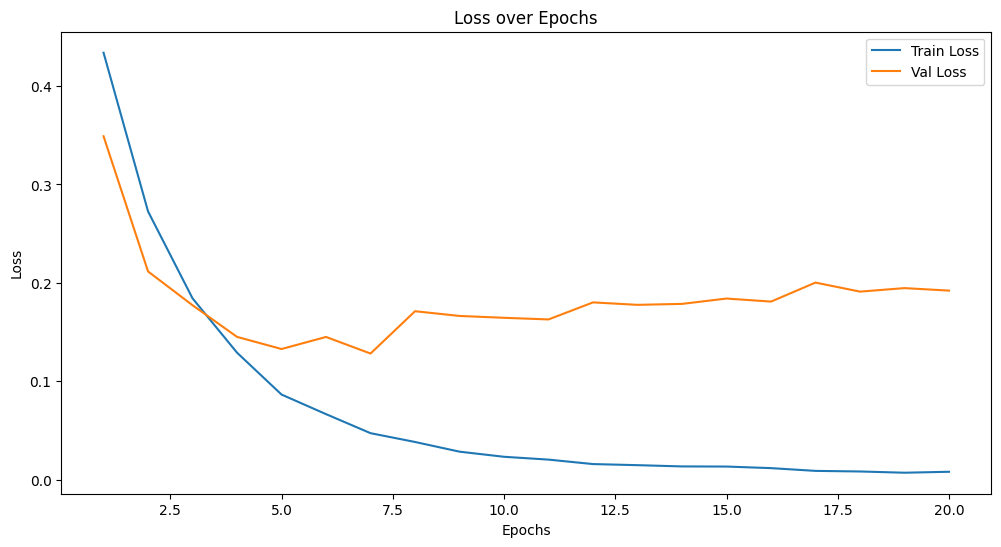

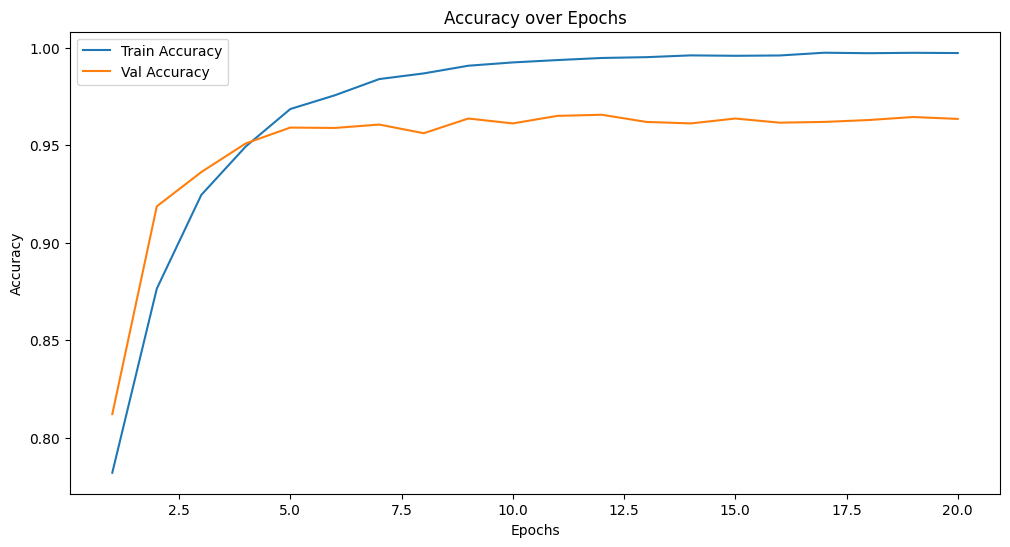

In [8]:
#------------------------ Vẽ biểu đồ kết quả------------------------------------
trainer.plot_metrics() # kết quả biểu đồ

**Test**

In [9]:
# class CustomELECTRAModel(nn.Module):
#     def __init__(self, model_name, num_labels=2):
#         super(CustomELECTRAModel, self).__init__()
#         self.electra = ElectraModel.from_pretrained(model_name)
#         self.attention = nn.MultiheadAttention(
#             embed_dim=self.electra.config.hidden_size, 
#             num_heads=8, 
#             batch_first=True
#         )
#         self.fc1 = nn.Linear(self.electra.config.hidden_size, 128)
#         self.fc2 = nn.Linear(128, num_labels)
#         self.dropout = nn.Dropout(0.3)
#         # Thêm lớp LayerNorm
#         self.layer_norm = nn.LayerNorm(128)

#     def forward(self, input_ids, attention_mask):
#         # Trích xuất embeddings từ ELECTRA
#         outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
#         # Attention pooling
#         attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool())
#         # Chọn CLS token làm đặc trưng đại diện
#         cls_token_output = attn_output[:, 0, :]  # CLS token tương ứng với đầu tiên của sequence output
#         # Fully connected layers
#         pooled_output = self.dropout(cls_token_output)  # Áp dụng dropout
#         fc1_output = torch.relu(self.fc1(pooled_output))
#         # Áp dụng Layer Normalization sau FC1
#         fc1_output = self.layer_norm(fc1_output)
#         logits = self.fc2(fc1_output)
#         return logits
# # Tải mô hình ELECTRA-Base
# model_name='google/electra-base-discriminator' 
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

# model_path = '/kaggle/input/model-test-sentiment-electra-v4/best_model_epoch_7_val_acc_0.9480.pth'
# # Load the trained model weights
# # model = CustomELECTRAModel(model_name=model_name)
# model = torch.load(model_path, map_location=torch.device('cuda'))
# # model.to('cuda' if torch.cuda.is_available() else 'cpu')
# model.eval()

Predicting on test data: 100%|██████████| 5171/5171 [00:55<00:00, 93.84it/s]


Mismatched samples saved to 'mismatch_samples.csv'
Classification Report:
              precision    recall  f1-score   support

    Positive     0.9678    0.9651    0.9664      2581
    Negative     0.9653    0.9680    0.9666      2590

    accuracy                         0.9665      5171
   macro avg     0.9665    0.9665    0.9665      5171
weighted avg     0.9665    0.9665    0.9665      5171



<Figure size 800x600 with 0 Axes>

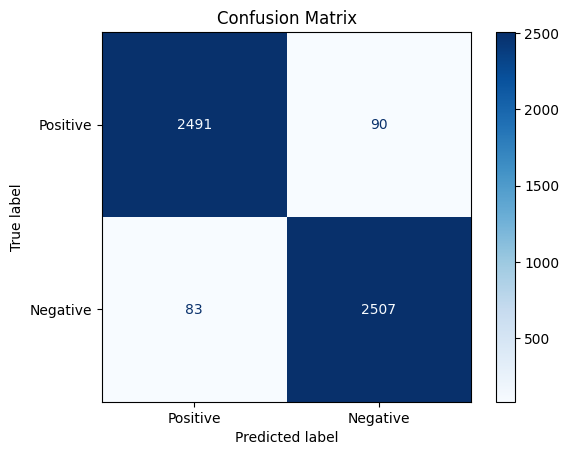

In [10]:
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay
class SimplePredictor:
    def __init__(self, model, tokenizer, max_length=128, device='cuda'):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device
    
    def predict_label(self, text):
        # Tokenize văn bản với độ dài tối đa
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        # Chuyển sang chế độ đánh giá
        self.model.eval()
        with torch.no_grad():
            logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = torch.argmax(logits, dim=-1).item()
        
        return prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Tạo đối tượng dự đoán
predictor = SimplePredictor(model, tokenizer, max_length=128, device=device)
# Tạo danh sách lưu các dòng dự đoán sai
mismatch_samples = []
augmented_data = []  # Danh sách lưu dữ liệu được nhân bản

# Dự đoán trên tập test và lưu mẫu dự đoán sai
y_true = test_data['label'].tolist()
y_pred = []
mismatch_samples = []

for idx, text in enumerate(tqdm(test_data['comment'], desc="Predicting on test data")):
    pred_label = predictor.predict_label(text)
    y_pred.append(pred_label)
    if pred_label != y_true[idx]:
        mismatch_samples.append({"Index": idx, "Text": text, "True Label": y_true[idx], "Predicted Label": pred_label})

# Lưu kết quả dự đoán sai ra file CSV
mismatch_samples_df = pd.DataFrame(mismatch_samples)
mismatch_samples_df.to_csv("/kaggle/working/mismatch_samples.csv", index=False, encoding='utf-8')
print("Mismatched samples saved to 'mismatch_samples.csv'")

# In báo cáo kết quả với 2 chữ số thập phân
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Positive", "Negative"], digits=4))

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Positive", "Negative"])

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# # Xử lý các mẫu dự đoán sai
# print("\nMismatched Samples:")
# for sample_idx, (idx, text, true_label, pred_label) in enumerate(mismatch_samples):
#     print(f"{sample_idx + 1}. Text: {text}")
#     print(f"   True Label: {'Positive' if true_label == 0 else 'Negative'}")
#     print(f"   Predicted Label: {'Positive' if pred_label == 0 else 'Negative'}")
    
#     # Hỏi người dùng có muốn đổi nhãn hay không
#     while True:
#         user_input = input("Change label? (1: Yes, 0: No): ")
#         if user_input in ['0', '1']:
#             user_input = int(user_input)
#             break
#         print("Invalid input! Please enter 1 (Yes) or 0 (No).")
    
#     # Nếu người dùng chọn đổi nhãn, cập nhật nhãn mới
#     if user_input == 1:
#         updated_labels[idx] = 1 - true_label  # Đổi nhãn 0 thành 1, hoặc 1 thành 0
#         print("Label updated.\n")
#     else:
#         # Nhân bản mẫu hiện tại thêm 5 lần
#         for _ in range(5):
#             augmented_data.append((text, true_label))
#         print("Data augmented 5 times.\n")

# # Tạo DataFrame từ dữ liệu nhân bản
# augmented_df = pd.DataFrame(augmented_data, columns=['comment', 'label'])

# # Gộp dữ liệu gốc và dữ liệu nhân bản
# test_data['label'] = updated_labels  # Cập nhật nhãn trong DataFrame
# final_data = pd.concat([test_data, augmented_df], ignore_index=True)

# # Xáo trộn dữ liệu
# final_data = shuffle(final_data, random_state=42)

# # Lưu lại dữ liệu đã cập nhật vào file .csv
# output_path = "/kaggle/working/dataset_process_v4.csv"
# final_data.to_csv(output_path, index=False, encoding='utf-8')
# print(f"Updated and augmented data saved to {output_path}.")

# **Test với bài báo thực tế**

In [11]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# import re
# import os

# device = torch.device('cuda')
# tokenizer = AutoTokenizer.from_pretrained("NlpHUST/vi-word-segmentation")
# model_seg = AutoModelForTokenClassification.from_pretrained("NlpHUST/vi-word-segmentation").to(device)

# nlp = pipeline("token-classification", model=model_seg, tokenizer=tokenizer)

In [12]:
# def word_weg(text, nlp):
#   ner_results = nlp(text)
#   example_tok = ""
#   for e in ner_results:
#       if "##" in e["word"]:
#           example_tok = example_tok + e["word"].replace("##","")
#       elif e["entity"] =="I":
#           example_tok = example_tok + "_" + e["word"]
#       elif ("." in e["word"]) or ("/" in e["word"]) or ("%" in e["word"]) or ("-" in e["word"]):
#         example_tok = example_tok + "" + e["word"]
#       else:
#         example_tok = example_tok + " " + e["word"]
#   return example_tok
    
# # Hàm tiền xử lý cho text
# def preprocessing_text(text, nlp):
#     # lower text
#     text = text.lower()

#     # remove special char
#     allowed_special_chars = r"\%-/"
#     allowed_chars = r"[^a-zA-Z0-9\s" + re.escape(allowed_special_chars) + r"àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐ]"
#     text = re.sub(allowed_chars, '', text)

#     # word segmentor
#     text = word_weg(text, nlp)

#     # remove stop word
#     with open('/kaggle/input/model-test/vietnamese.txt', 'r', encoding='utf-8') as f:
#         stop_words = set(f.read().strip().split('\n'))
#     words = text.split()
#     filtered_words = [word for word in words if word not in stop_words]
#     text =' '.join(filtered_words)

#     return text

# def split_sentence_into_chunks(sentence, max_length=512):
#     """Cắt câu dài thành các đoạn nhỏ hơn hoặc bằng max_length ký tự."""
#     chunks = []
#     while len(sentence) > max_length:
#         # Tìm vị trí dấu cách gần nhất trước giới hạn max_length
#         split_pos = sentence[:max_length].rfind(" ")
#         if split_pos == -1:  # Nếu không tìm thấy dấu cách
#             split_pos = max_length
#         chunks.append(sentence[:split_pos].strip())
#         sentence = sentence[split_pos:].strip()
#     if sentence:  # Thêm phần còn lại của câu
#         chunks.append(sentence)
#     return chunks

# def split_text_with_long_sentences(text, max_length=512):
#     """Cắt văn bản thành nhiều đoạn nhỏ hơn hoặc bằng max_length ký tự, bao gồm cả câu dài."""
#     text = text.strip()
#     sentences = re.split(r'(?<=[.])', text)  # Tách theo câu, giữ lại dấu chấm
#     chunks = []
#     for sentence in sentences:
#         sentence = sentence.strip()
#         if len(sentence) > max_length:
#             # Nếu câu vượt quá max_length, cắt thành các đoạn nhỏ
#             chunks.extend(split_sentence_into_chunks(sentence, max_length))
#         else:
#             # Nếu câu không vượt quá max_length, thêm vào danh sách
#             chunks.append(sentence)
#     return chunks
    
# def preprocessing_data(text, nlp):
    
#     sentences = split_text_with_long_sentences(text, max_length=512)
    
#     # Loại bỏ các câu rỗng hoặc chỉ chứa khoảng trắng
#     sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    
#     # Nối kết quả sau xử lý bằng dấu cách
#     text = " ".join(preprocessing_text(sentence, nlp) for sentence in sentences)
#     return text
    


# def classify_article_with_percentage(article_text):
#     """
#     Hàm nhận diện tin giả cho một bài báo và trả về nhãn cùng tỷ lệ phần trăm dự đoán.
    
#     Args:
#         article_text (str): Nội dung bài báo cần phân loại.
        
#     Returns:
#         str: Kết quả phân loại ("Real" hoặc "Fake").
#         dict: Tỷ lệ phần trăm dự đoán cho từng nhãn.
#     """
#     # Lấy các dự đoán từ các cửa sổ trượt
#     token_windows = predictor.sliding_window_tokenize(article_text)
#     predictions = []
#     predictor.model.eval()
#     with torch.no_grad():
#         for window in token_windows:
#             inputs = {
#                 'input_ids': torch.tensor([window]).to(predictor.device),
#                 'attention_mask': torch.tensor([[1 if token != predictor.tokenizer.pad_token_id else 0 for token in window]]).to(predictor.device)
#             }
#             logits = predictor.model.forward(inputs['input_ids'], inputs['attention_mask'])
#             predictions.append(torch.argmax(logits, dim=1).item())
    
#     # Tính tỷ lệ phần trăm
#     label_count = Counter(predictions)
#     total_windows = len(predictions)
#     percentage = {label: (count / total_windows) * 100 for label, count in label_count.items()}
    
#     # Quyết định nhãn cuối cùng
#     if label_count[0] == label_count[1]:
#         final_label = 1
#     else:
#         final_label = label_count.most_common(1)[0][0]
    
#     return "Real" if final_label == 0 else "Fake", percentage


In [13]:

# # Nhập nội dunng bài báo

# text="""Theo Luật sửa đổi, doanh nghiệp tiếp tục đóng 2% quỹ tiền lương làm căn cứ đóng bảo hiểm xã hội cho nhân viên vào quỹ công đoàn
# """



# print("/nNội dung bài báo gốc: ",text)

# text_process=preprocessing_data(text,nlp)
# print("\nNội dung bài báo đã tiền xử lý: ",text_process)

# article_text= text_process

# # Phân loại bài báo và lấy tỷ lệ phần trăm
# result, percentages = classify_article_with_percentage(article_text)

# print(f"\nKết quả nhận diện: {result}")
# print(f"\nTỷ lệ dự đoán: Real = {percentages.get(0, 0):.2f}%, Fake = {percentages.get(1, 0):.2f}%")